# Objaverse-XL: Download & Visualize Random 3D Objects

This notebook demonstrates how to:
1. Download random objects from Objaverse-XL (10M+ 3D objects)
2. Inspect their metadata and geometry
3. Visualize them inline or save renders

# Install dependencies
!pip install -q objaverse trimesh pillow numpy "pyglet<2"

In [1]:
import objaverse
import trimesh
import random
import numpy as np
from PIL import Image
from IPython.display import display, HTML
import io

## 1. Load Available Object UIDs

In [2]:
import os
os.environ['BASE_PATH']="./objaverse"

In [3]:
objaverse._VERSIONED_PATH="./objaverse/hf-objaverse-v1"
objaverse.BASE_PATH="./objaverse"

In [4]:
# Load all available UIDs (this downloads a small metadata file)

uids = objaverse.load_uids()
print(f"Total objects available: {len(uids):,}")

Total objects available: 798,759


## 2. Sample Random Objects

In [29]:
# Sample 10 random objects
NUM_SAMPLES = int(len(uids) * (0.01/100))
print(f'Choosing {NUM_SAMPLES} samples') 
random.seed(42)  # For reproducibility
sample_uids = random.sample(uids, NUM_SAMPLES)

print("Selected UIDs:")
for uid in sample_uids:
    print(f"  {uid}")

Choosing 79 samples
Selected UIDs:
  f82039689f504922995936c68484aa61
  fb42332b3f5e491cb0c4b5ba7ed6f374
  d633b522306b4499a8e6f1ac5f517864
  89da97b84f4d4fbc825bf3e914d45e92
  32aaba5aa1954cb898111bf884404039
  f84c8cbd56d94be18a727c66de2c2d51
  6afcf8814d494372a4f3f7e3b99219ba
  38cb6584bb734d729baf712da41b141f
  f9b8b1cea04243a7bf706c4565027187
  306aa51bb3c24464886dce788547e6cb
  df4d2da4e9934b82b30f9bcab685a0fd
  45509feed4534fa1a34567ae82c457cf
  b86569c202fa455b8d221e90c5588cc7
  00ae6eda19634ee6b0a4a52789c9ff90
  bfd6abe69bde4ee7806ef3fa483b0655
  1b1c987aa5914a4f85eecca0a6ba9b4e
  7842c2ad6fe74224974d64958baea75d
  a018d452856f4452958e081f77cdc253
  9e6bd36b7b94412a9c71fdc34561a934
  6845849028774ca782f0e2e221c69944
  60a206c7952c420e844640de850f4fcf
  d0ca35386b0b48418f8669da1bea0923
  61955029fd2c48d9a6eb6c6097f93b6c
  329684e1e63d4d16bcf519cc9571c1fb
  06d70683684b4b4cbc3da27c5507ee6a
  71aad2b07e5a4d4bb75f4acbdb6a1aa2
  4954590a8ea7404f9c4a83a446313f07
  eac6c10064684567a0

## 3. Download Objects

In [30]:
# Download the sampled objects (returns dict: uid -> local filepath)
objects = objaverse.load_objects(
    uids=sample_uids,
    download_processes=1  # Parallel downloads
)

print(f"Downloaded {len(objects)} objects")
for uid, path in list(objects.items())[:3]:
    print(f"  {uid[:8]}... -> {path}")

Downloaded 1 / 69 objects
Downloaded 2 / 69 objects
Downloaded 3 / 69 objects
Downloaded 4 / 69 objects
Downloaded 5 / 69 objects
Downloaded 6 / 69 objects
Downloaded 7 / 69 objects
Downloaded 8 / 69 objects
Downloaded 9 / 69 objects
Downloaded 10 / 69 objects
Downloaded 11 / 69 objects
Downloaded 12 / 69 objects
Downloaded 13 / 69 objects
Downloaded 14 / 69 objects
Downloaded 15 / 69 objects
Downloaded 16 / 69 objects
Downloaded 17 / 69 objects
Downloaded 18 / 69 objects
Downloaded 19 / 69 objects
Downloaded 20 / 69 objects
Downloaded 21 / 69 objects
Downloaded 22 / 69 objects
Downloaded 23 / 69 objects
Downloaded 24 / 69 objects
Downloaded 25 / 69 objects
Downloaded 26 / 69 objects
Downloaded 27 / 69 objects
Downloaded 28 / 69 objects
Downloaded 29 / 69 objects
Downloaded 30 / 69 objects
Downloaded 31 / 69 objects
Downloaded 32 / 69 objects
Downloaded 33 / 69 objects
Downloaded 34 / 69 objects
Downloaded 35 / 69 objects
Downloaded 36 / 69 objects
Downloaded 37 / 69 objects
Downloaded

## 4. Load Annotations (Metadata)

In [31]:
# Load annotations for our sampled objects
annotations = objaverse.load_annotations(sample_uids)

# Show sample annotation
sample_uid = sample_uids[0]
ann = annotations.get(sample_uid, {})
print(f"Sample annotation for {sample_uid}:")
print(f"  Name: {ann.get('name', 'Unknown')}")
print(f"  Categories: {[c.get('name') for c in ann.get('categories', [])]}")
print(f"  License: {ann.get('license', 'Unknown')}")

 98%|█████████▊| 59/60 [01:20<00:01,  1.36s/it]

Sample annotation for f82039689f504922995936c68484aa61:
  Name: Grape Fanta Can
  Categories: ['food-drink']
  License: by


## 5. Load & Inspect 3D Geometry

In [32]:
def get_mesh_stats(mesh_or_scene):
    """Get geometry statistics from a mesh or scene."""
    if isinstance(mesh_or_scene, trimesh.Scene):
        total_verts = sum(len(g.vertices) for g in mesh_or_scene.geometry.values() if hasattr(g, 'vertices'))
        total_faces = sum(len(g.faces) for g in mesh_or_scene.geometry.values() if hasattr(g, 'faces'))
        return {
            'type': 'Scene',
            'num_geometries': len(mesh_or_scene.geometry),
            'vertices': total_verts,
            'faces': total_faces
        }
    else:
        return {
            'type': 'Mesh',
            'num_geometries': 1,
            'vertices': len(mesh_or_scene.vertices) if hasattr(mesh_or_scene, 'vertices') else 0,
            'faces': len(mesh_or_scene.faces) if hasattr(mesh_or_scene, 'faces') else 0
        }

# Load all meshes
meshes = {}
for uid, filepath in objects.items():
    try:
        mesh = trimesh.load(filepath)
        meshes[uid] = mesh
        stats = get_mesh_stats(mesh)
        name = annotations.get(uid, {}).get('name', 'Unknown')[:30]
        print(f"{name:<30} | {stats['type']:<6} | {stats['vertices']:>7,} verts | {stats['faces']:>7,} faces")
    except Exception as e:
        print(f"Error loading {uid}: {e}")

Grape Fanta Can                | Scene  |  16,679 verts |  31,958 faces
Pipe sword game ready          | Scene  |   6,291 verts |   8,696 faces
Marvel's Thor - Stormbreaker ( | Scene  |   5,198 verts |   3,168 faces
Dangling earring with repeatin | Scene  |  29,835 verts |  71,226 faces
1010_4_2                       | Scene  |   1,009 verts |     514 faces
Niamh Tirion Cadi              | Scene  |  24,828 verts |  25,110 faces
New Female Raptor Another      | Scene  | 189,793 verts | 329,926 faces
Coffee Maker                   | Scene  |  91,772 verts |  85,366 faces
Ramp with uv                   | Scene  |  13,345 verts |  12,320 faces
Loros Primarios                | Scene  |  24,589 verts |  39,306 faces
Dendera zodiac copy            | Scene  | 315,963 verts | 500,000 faces
16.03                          | Scene  |  15,125 verts |  18,928 faces
Quake 1 DM4 - The Bad Place -  | Scene  |   7,212 verts |   4,801 faces
Ejemplo 3                      | Scene  |     610 verts |     61

## 6. Render & Visualize

In [33]:
import numpy as np
from PIL import Image

def render_mesh_simple(mesh_or_scene, resolution=(400, 300)):
    """Render using trimesh's built-in preview without OpenGL."""
    try:
        # Try the standard approach first
        scene = mesh_or_scene if isinstance(mesh_or_scene, trimesh.Scene) else trimesh.Scene(mesh_or_scene)
        png_bytes = scene.save_image(resolution=resolution)
        if png_bytes:
            return Image.open(io.BytesIO(png_bytes))
    except Exception:
        pass
    
    # Fallback: create a simple orthographic projection manually
    if isinstance(mesh_or_scene, trimesh.Scene):
        mesh = mesh_or_scene.dump(concatenate=True)
    else:
        mesh = mesh_or_scene
    
    # Get vertices and project to 2D
    vertices = mesh.vertices.copy()
    
    # Center and normalize
    vertices -= vertices.mean(axis=0)
    scale = np.abs(vertices).max()
    if scale > 0:
        vertices /= scale
    
    # Simple orthographic projection (drop Z)
    width, height = resolution
    points_2d = vertices[:, :2]
    points_2d = (points_2d + 1) / 2  # normalize to 0-1
    points_2d[:, 0] *= width
    points_2d[:, 1] *= height
    
    # Create image
    img = Image.new('RGB', resolution, color=(40, 40, 40))
    pixels = img.load()
    
    for x, y in points_2d.astype(int):
        if 0 <= x < width and 0 <= y < height:
            pixels[x, height - 1 - y] = (200, 200, 200)
    
    return img

Rendering objects...

### Grape Fanta Can
UID: `f82039689f504922995936c68484aa61`


/tmp/ipykernel_2269817/275752486.py:17: DeprecationWarning: `Scene.dump(concatenate=True)` DEPRECATED FOR REMOVAL APRIL 2025: replace with `Scene.to_geometry()`
  mesh = mesh_or_scene.dump(concatenate=True)


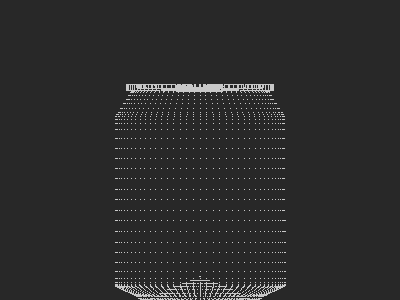


### Pipe sword game ready
UID: `fb42332b3f5e491cb0c4b5ba7ed6f374`


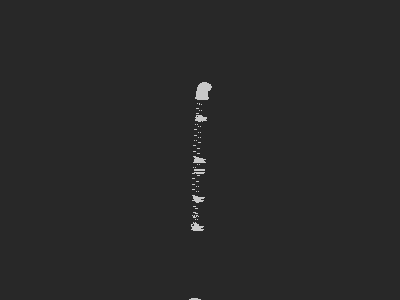


### Marvel's Thor - Stormbreaker (Asgardian Handle)
UID: `d633b522306b4499a8e6f1ac5f517864`


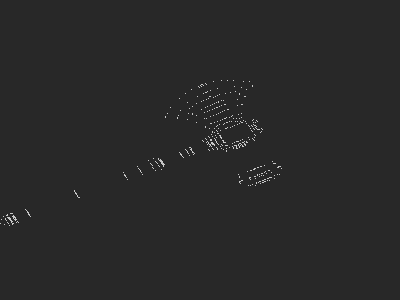


### Dangling earring with repeating pattern
UID: `89da97b84f4d4fbc825bf3e914d45e92`


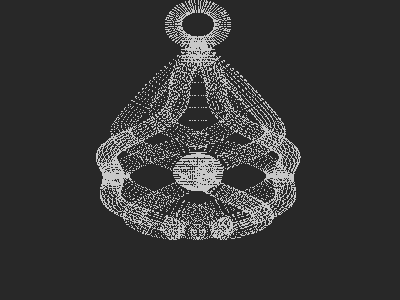


### 1010_4_2
UID: `32aaba5aa1954cb898111bf884404039`


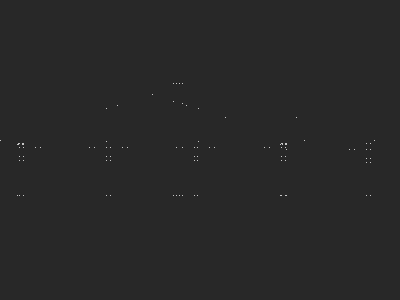


### Niamh Tirion Cadi
UID: `f84c8cbd56d94be18a727c66de2c2d51`


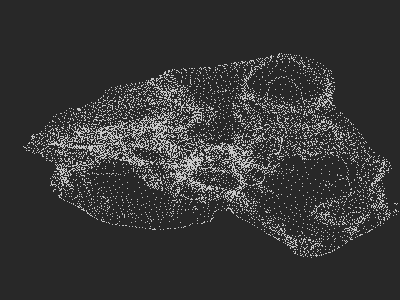


### New Female Raptor Another
UID: `6afcf8814d494372a4f3f7e3b99219ba`


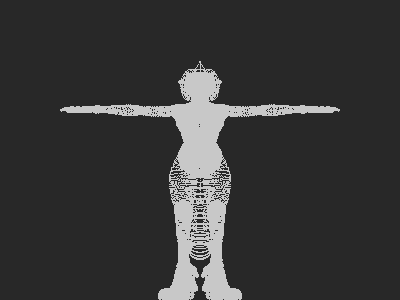


### Coffee Maker
UID: `38cb6584bb734d729baf712da41b141f`


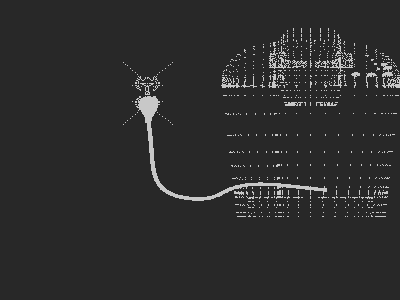


### Ramp with uv
UID: `f9b8b1cea04243a7bf706c4565027187`


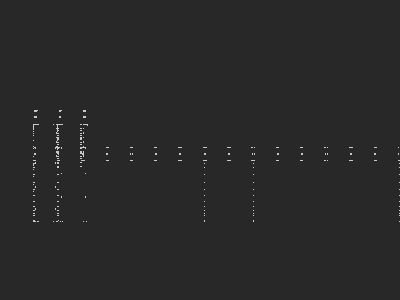


### Loros Primarios
UID: `306aa51bb3c24464886dce788547e6cb`


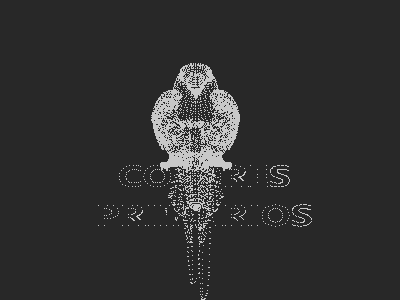


### Dendera zodiac copy
UID: `df4d2da4e9934b82b30f9bcab685a0fd`


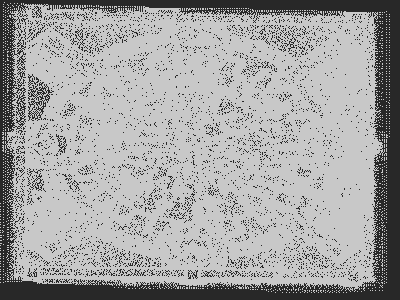


### 16.03
UID: `45509feed4534fa1a34567ae82c457cf`


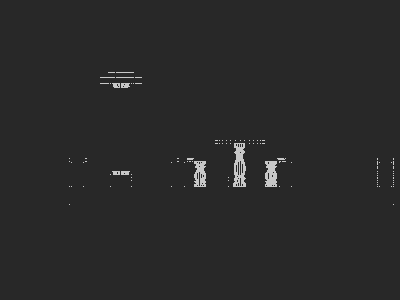


### Quake 1 DM4 - The Bad Place - Deathmatch
UID: `b86569c202fa455b8d221e90c5588cc7`


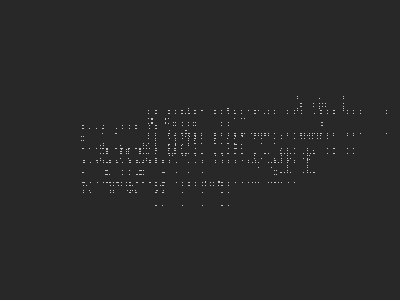


### Ejemplo 3
UID: `00ae6eda19634ee6b0a4a52789c9ff90`


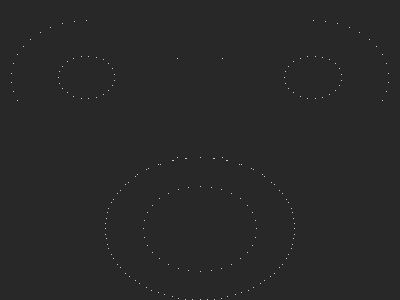


### Люстра 2021-5P Favourite
UID: `bfd6abe69bde4ee7806ef3fa483b0655`


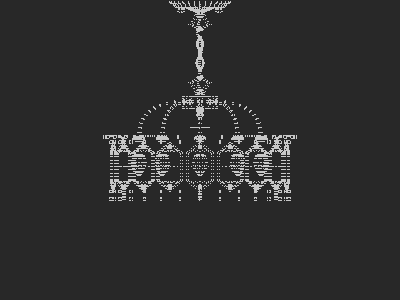


### Ghostkbk
UID: `1b1c987aa5914a4f85eecca0a6ba9b4e`


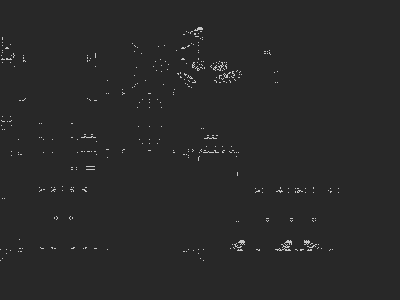


### 136146J
UID: `7842c2ad6fe74224974d64958baea75d`


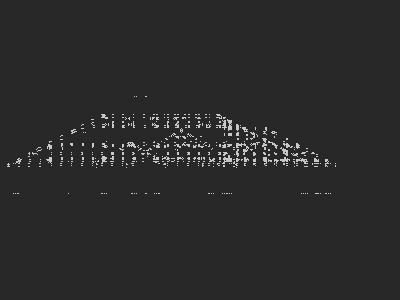


### PBR Stylized Grass & Stone
UID: `a018d452856f4452958e081f77cdc253`


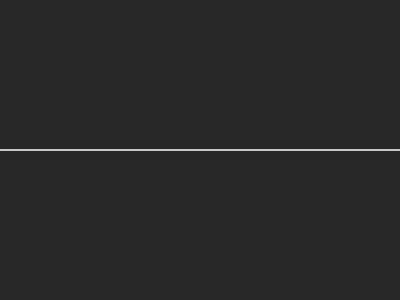


### 170613_211114
UID: `9e6bd36b7b94412a9c71fdc34561a934`


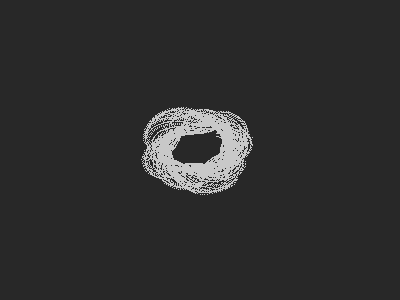


### Sitting Clap(4)
UID: `6845849028774ca782f0e2e221c69944`


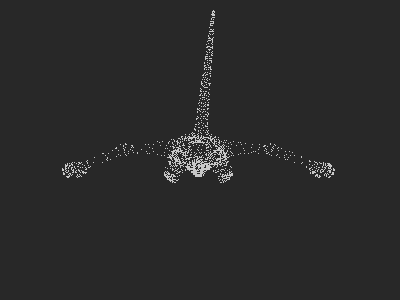


### JanuarySculpts(01-Mouth&Nose)
UID: `60a206c7952c420e844640de850f4fcf`


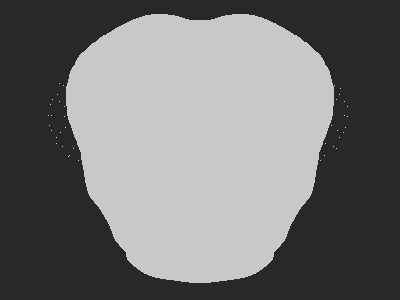


### Grotta di Croce Vecchia - Lapis Specularis mine
UID: `d0ca35386b0b48418f8669da1bea0923`


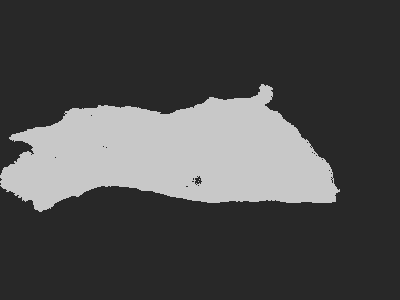


### CBC1 171
UID: `61955029fd2c48d9a6eb6c6097f93b6c`


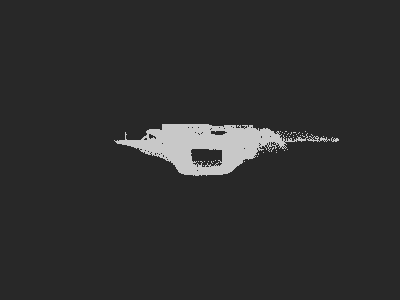


### Mutant Rat
UID: `329684e1e63d4d16bcf519cc9571c1fb`


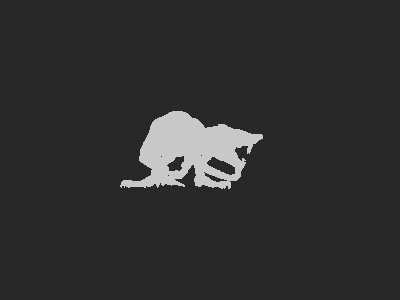


### Levantamento - MC - Lote R6
UID: `06d70683684b4b4cbc3da27c5507ee6a`


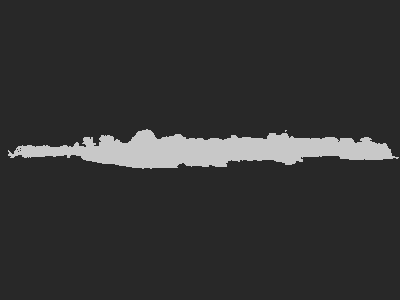


### Martinsburg Joints Low Res
UID: `71aad2b07e5a4d4bb75f4acbdb6a1aa2`


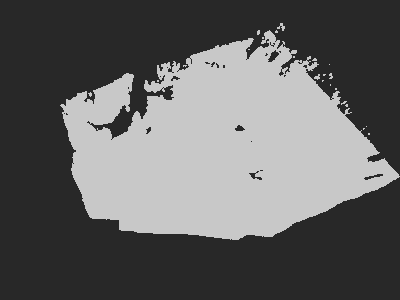


### MSB12
UID: `4954590a8ea7404f9c4a83a446313f07`


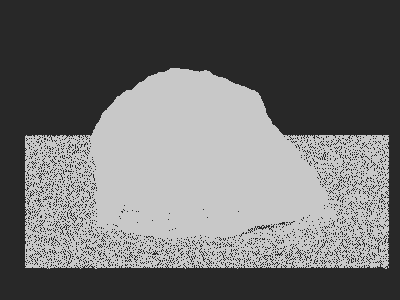


### 100kin bottle cap
UID: `eac6c10064684567a054bab3824924a8`


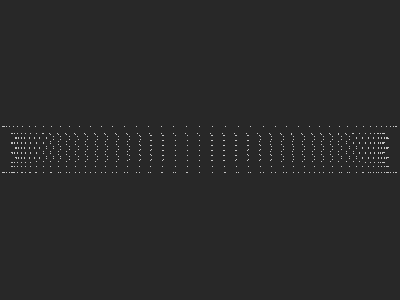


### EVE3D - Ojos
UID: `37a5a43654ff4b3090d4f42a4a2f59b5`


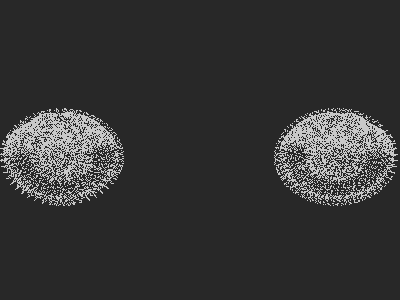


### VSK-94
UID: `e2aecaea83e840cab77384182ddea0f3`


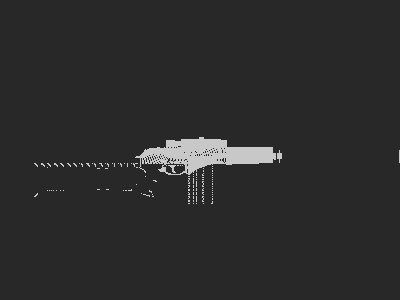


### Kirby (Rainbow Curse) Model
UID: `20e207c435c241b392cf77b3a7507441`


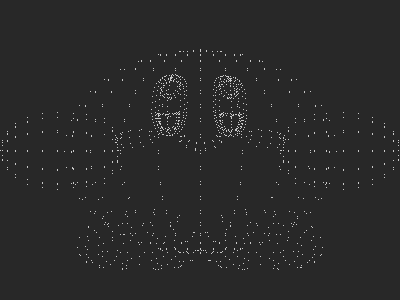


### Nothic UPDATED Presupported
UID: `2f9bcbdeaea74f8c8915e51da414df3c`


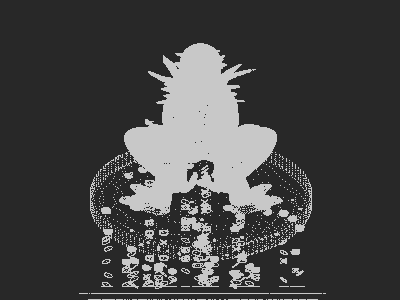


### Basement hobby room
UID: `918bf1b83aa5473a849e58ff466602f5`


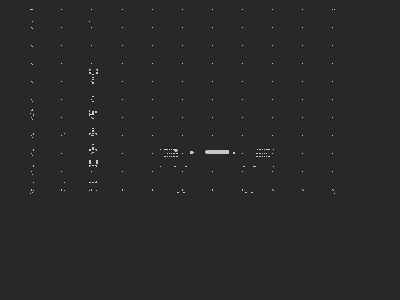


### Avatar
UID: `f81de979af8440f6aa578f40d26167bd`


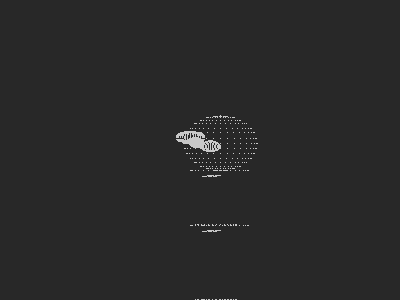


### Pizzeria 3657
UID: `2c378ccc8db7420a8a189bed03798601`


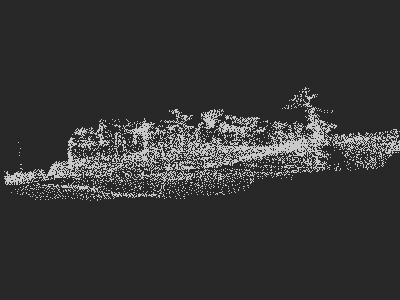


### 55.02
UID: `410293203f0f449696981afbcc4f6873`


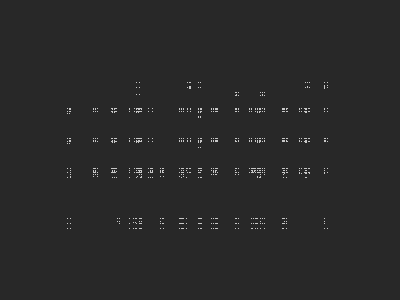


### FKIP UNSRI
UID: `8ee80065fb2144e4bce9d14cccca9ff3`


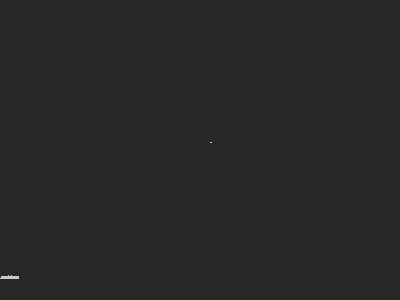


### COADS_71-50
UID: `c701cc92af064825935891380adcad85`


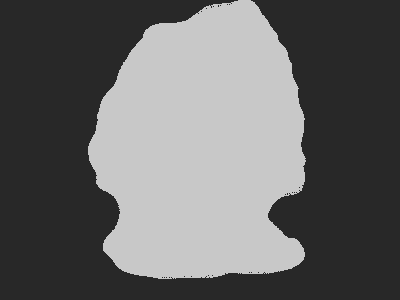


### Version 4
UID: `89e3b742676c40179969772eb6879f41`


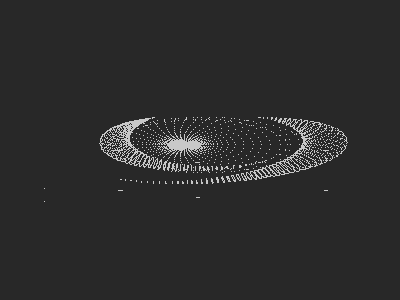


### Coffee Late Cup
UID: `bf24581d4eff47c389827a444987da06`


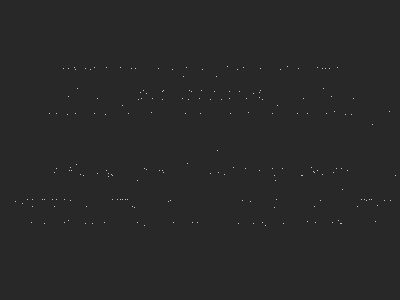


### Porcelain Doll 01
UID: `0145c1e4894e450ea1812cb5af891a72`


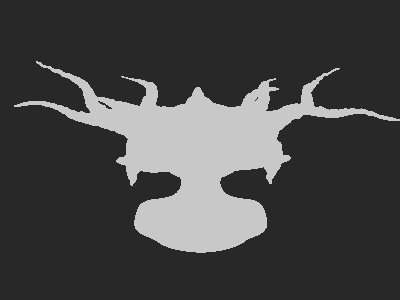


### Invisible Motorcycle (WIP)
UID: `fa0fd60e2ce342b3ac13d8c97ae8c43c`


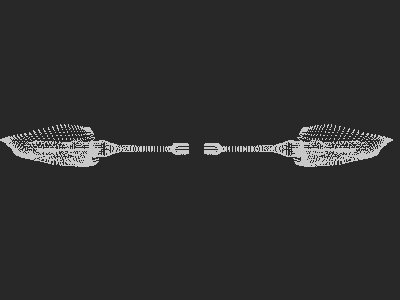


### Tihver�inen Raimo altair
UID: `84326404951040feb1c3571c66dc73b5`


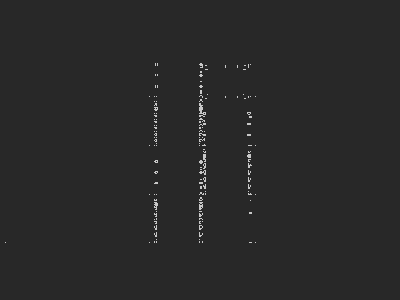


### Civilization One Intro - Earth
UID: `95391b2c6788410b9020b43056d034d5`


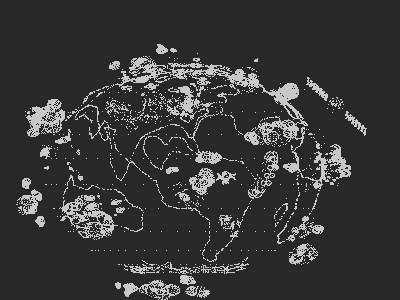


### Apartment
UID: `af460cf7850a4425a56dd8bc57f97c6d`


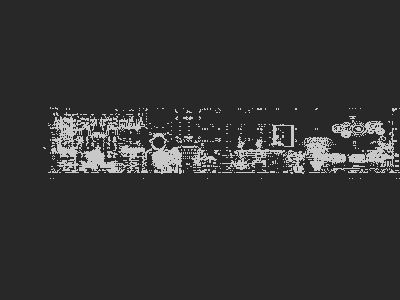


### 梅屋敷　なんか机がめり込んでてビビった
UID: `2591d4d1395a4610975499df9c3bf0a8`


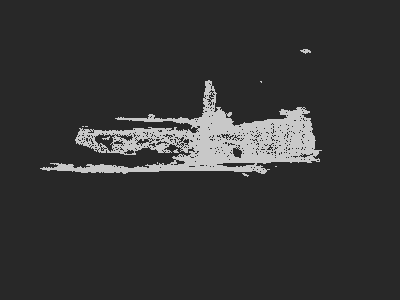


### Rat - Nomad Sculpt
UID: `5492bdbffb5e443d8839e044de5b62de`


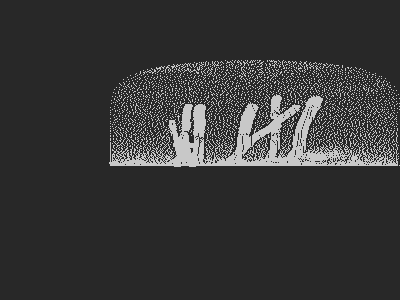


### Kylie P
UID: `4ec6ae76dc2f4377894fbc73db2cb322`


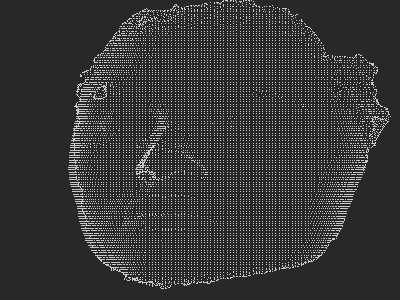


### Saal V1
UID: `dc719c32578e439b9bcde737553cbb07`


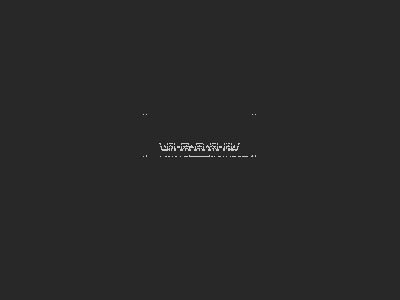


### Low Poly | SHARK
UID: `a4e5e0f3fd3d4af4b6dca5922784acb6`


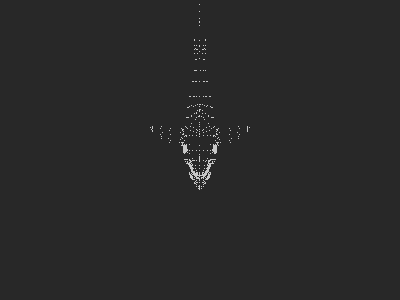


### Botella de cerámica Huaura
UID: `e19bd5905226449ca32354d9b59302fd`


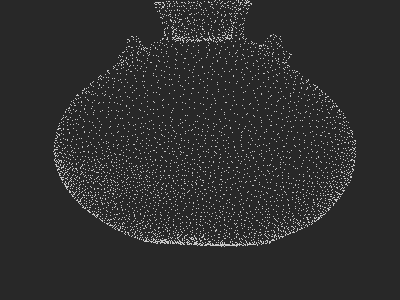


### Appartement T4 81m2
UID: `97938b8711724652b45b1f8c7b4b7116`


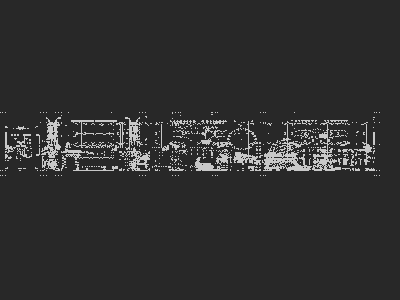


### Porites lutea
UID: `a4e8dccce7404907a9b56d5911078bcb`


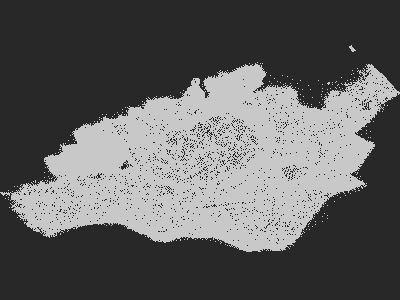


### Panes
UID: `7cccbc1491fd4412a347d203e2aaab4f`


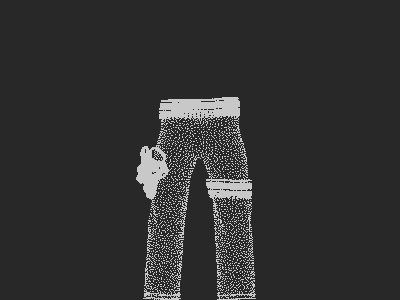


### 23200C
UID: `391ecf876e944b9886178faa45933d38`


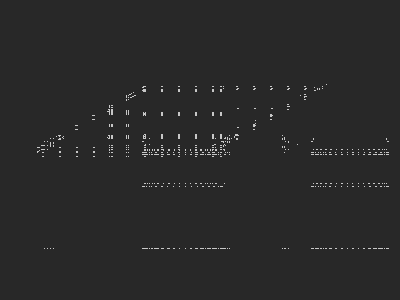


### Silver Cup
UID: `f7a0bf72401a4497b2e5399b87f7dc0c`


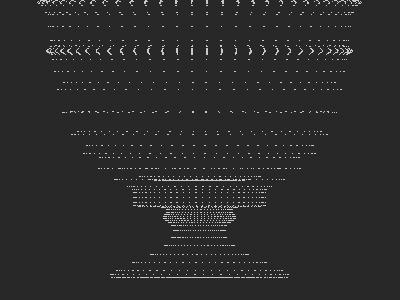


### 210775
UID: `022c296ccade4ac7bf6dbbd04dab9342`


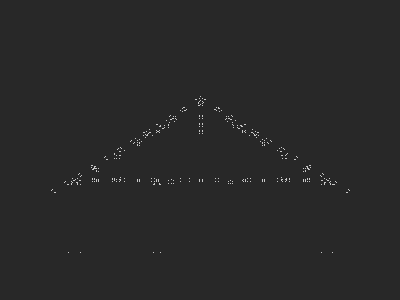


### Glasses
UID: `beea5043455f4831906dbb0d856b3faa`


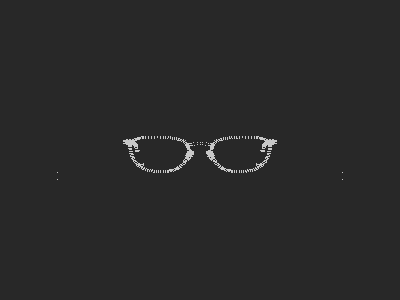


### Simple Car - Model A 100 Sport
UID: `f6f6006750ec47578b73bc25064b810f`


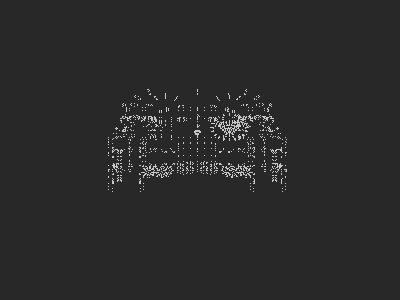


### Part2_Re_Formed
UID: `96ee1842cdd64f6c931f9a4fbfeff5e7`


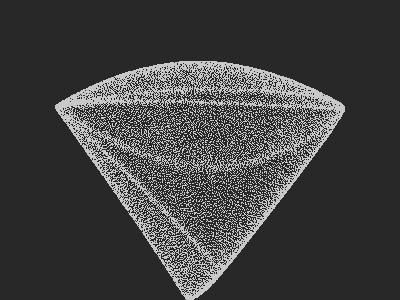


### house 1
UID: `3a741d3211fb4871bbf434617a8b6c0f`


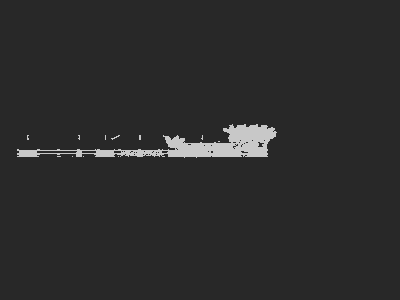


### Вариант 2
UID: `36d4c024253d41ab8346f5109690303a`


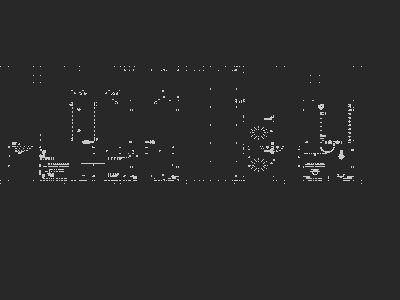


### Patterson021002 Chair
UID: `3ad05cdfe560433c96d5172bc3c00852`


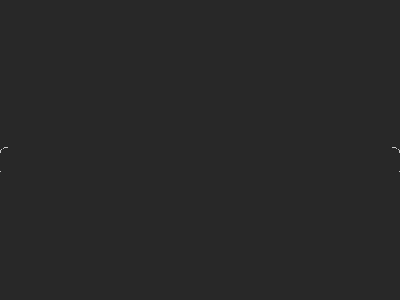


### Grądy - montaż
UID: `7f02efae906243f184a53997be60d9f4`


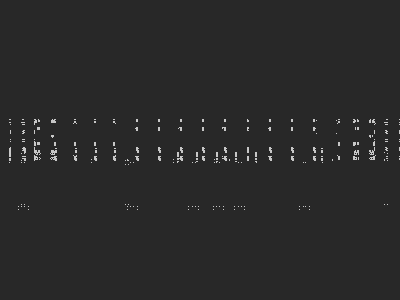


### Легенда брикс
UID: `7f1201a69a1d4d53bac72e851b2cb1d2`


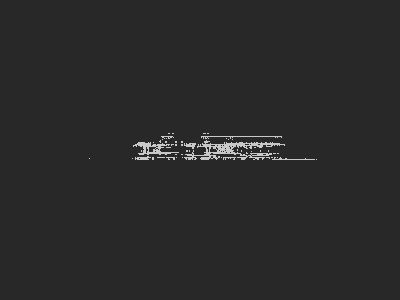


### Capitel
UID: `e6ea945cb96e44a9a426bd32a7754e29`


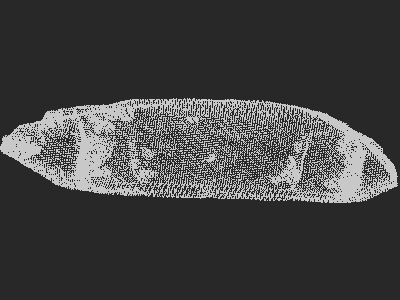


### Nike Dunk
UID: `991ea3b9799d49e2b27713337c6ec4d5`


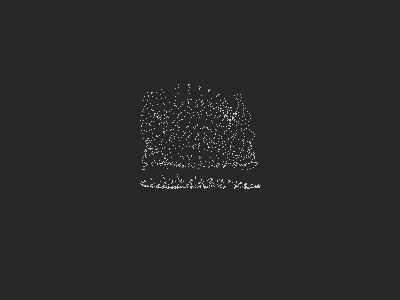


### headset5
UID: `07b44d8694d64c4fabaf49728cea6d52`


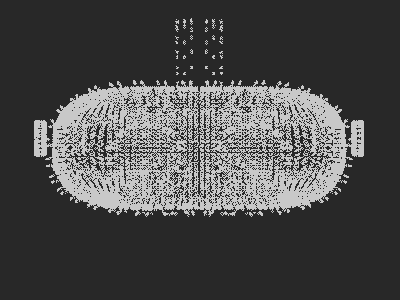


### combelles-salon-a-bas
UID: `69373fad6b6b4532ac303e20eb1930bd`


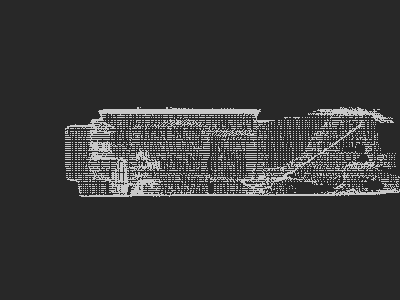


### Maui - 2
UID: `77c0d187bcac40aca483e8cc8a1dd712`


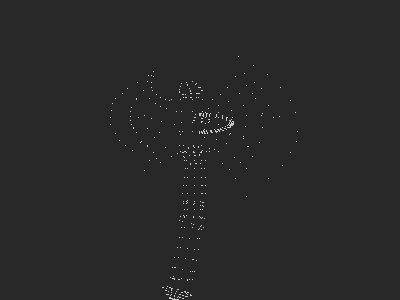


### Oggy Oggy
UID: `12c40cc1bcf644ccbc052eb1e15b0a0a`


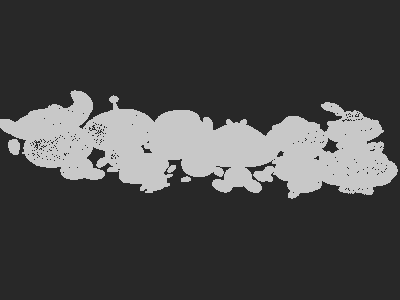


### Large Cannon
UID: `4f96dd64302e4728afcdef3b7cf96a4c`


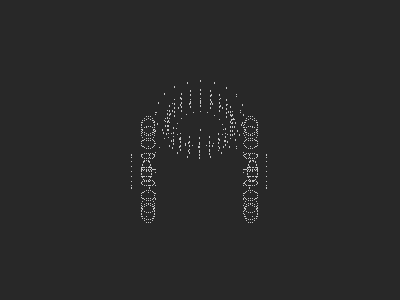


### Freddy Frostbear | FNaF AR Special Delivery
UID: `79506e2a4fe24cd39c1e75339ed50a8d`


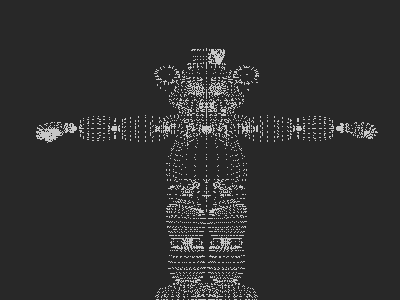


### dxy Orbital
UID: `b1076a45fd8648698dadfe36fe22cf95`


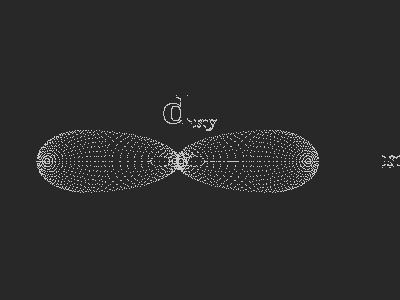


### Smiley \(´▽｀)/
UID: `24384bffb5494af7b1026af3ce7130c1`


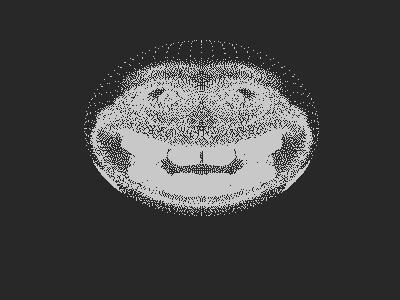


### Quadrante solare
UID: `42ade2ed5c2f42c4904e283922b960c2`


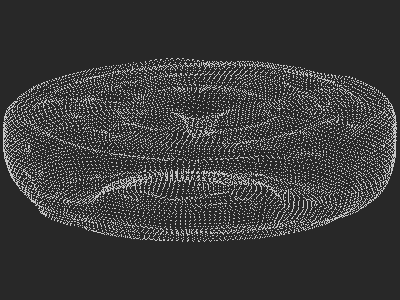


### GUITARFISH FOSSIL 95 Million years old Lebanon
UID: `d8e8a4325deb4aeabd891672dd4837a8`


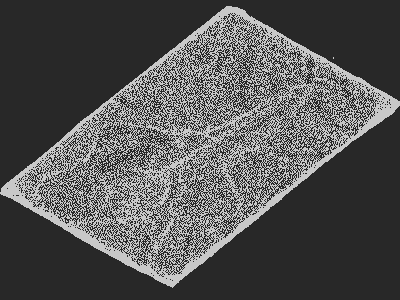


### Foxy
UID: `157becd6433b41cf8784dc1b39081e67`


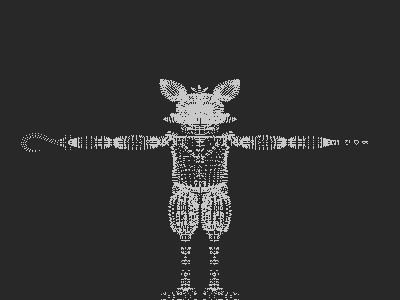


### Minecraft 3D Model ~ Thanos' Throne Chair
UID: `01037539e75a4f1aa01617adb05969e8`


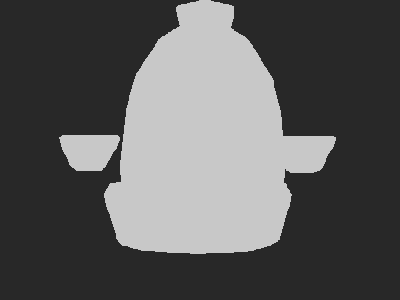

In [34]:
# Render all objects
print("Rendering objects...\n")
for uid, mesh in meshes.items():
    name = annotations.get(uid, {}).get('name', 'Unknown')
    print(f"### {name}")
    print(f"UID: `{uid}`")
    try:
        img = render_mesh_simple(mesh)
        display(img)
    except Exception as e:
        print(f"Render error: {e}")
    print()

## 7. Interactive Viewing (Optional)

If you have a display available, you can use trimesh's interactive viewer:

In [10]:
# Uncomment to open interactive 3D viewer for first mesh
# first_mesh = list(meshes.values())[0]
# first_mesh.show()

## 8. Save Renders to Files

In [ ]:
import os

OUTPUT_DIR = "./objaverse_renders"
os.makedirs(OUTPUT_DIR, exist_ok=True)

for uid, mesh in meshes.items():
    name = annotations.get(uid, {}).get('name', 'Unknown').replace('/', '_')[:30]
    filename = f"{uid[:8]}_{name}.png"
    filepath = os.path.join(OUTPUT_DIR, filename)
    
    try:
        img = render_mesh_simple(mesh, resolution=(800, 600))
        img.save(filepath)
        print(f"Saved: {filepath}")
    except Exception as e:
        print(f"Error saving {uid}: {e}")

print(f"\nAll renders saved to: {OUTPUT_DIR}/")

/tmp/ipykernel_2269817/275752486.py:17: DeprecationWarning: `Scene.dump(concatenate=True)` DEPRECATED FOR REMOVAL APRIL 2025: replace with `Scene.to_geometry()`
  mesh = mesh_or_scene.dump(concatenate=True)


Saved: ./objaverse_renders/f8203968_Grape Fanta Can.png
Saved: ./objaverse_renders/fb42332b_Pipe sword game ready.png
Saved: ./objaverse_renders/d633b522_Marvel's Thor - Stormbreaker (.png
Saved: ./objaverse_renders/89da97b8_Dangling earring with repeatin.png
Saved: ./objaverse_renders/32aaba5a_1010_4_2.png
Saved: ./objaverse_renders/f84c8cbd_Niamh Tirion Cadi.png
Saved: ./objaverse_renders/6afcf881_New Female Raptor Another.png
Saved: ./objaverse_renders/38cb6584_Coffee Maker.png
Saved: ./objaverse_renders/f9b8b1ce_Ramp with uv.png
Saved: ./objaverse_renders/306aa51b_Loros Primarios.png
Saved: ./objaverse_renders/df4d2da4_Dendera zodiac copy.png
Saved: ./objaverse_renders/45509fee_16.03.png
Saved: ./objaverse_renders/b86569c2_Quake 1 DM4 - The Bad Place - .png
Saved: ./objaverse_renders/00ae6eda_Ejemplo 3.png
Saved: ./objaverse_renders/bfd6abe6_Люстра 2021-5P Favourite.png
Saved: ./objaverse_renders/1b1c987a_Ghostkbk.png
Saved: ./objaverse_renders/7842c2ad_136146J.png
Saved: ./objaver

## Additional: Filter by Category

You can also filter objects by metadata before downloading:

In [ ]:
# Load all annotations (takes a few minutes first time)
# all_annotations = objaverse.load_annotations()

# # Filter for specific category
# vehicle_uids = [
#     uid for uid, ann in all_annotations.items()
#     if any('vehicle' in c.get('name', '').lower() for c in ann.get('categories', []))
# ]
# print(f"Found {len(vehicle_uids)} vehicle objects")